[View in Colaboratory](https://colab.research.google.com/github/wonwooddo/NALU-test/blob/master/Nalu_test.ipynb)

# Helpful functions

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(x_train=None, y_train=None, x_test=None, y_test=None, 
                          mlp_pred=None, nalu_pred=None, train_man=-2, train_min=1):
  
  fig = plt.figure(figsize=(9, 5))
  ax = fig.add_subplot(111)

  if x_train is not None:
    ax.plot(x_train, y_train, c="r", label="Train data", zorder=10)
  if x_test is not None:
    ax.plot(x_test, y_test, c="g", label="Test data")  
  if mlp_pred is not None:
    ax.plot(x_test, mlp_pred, c="b", label="MLP predicted")
  if nalu_pred is not None:
    ax.plot(x_test, nalu_pred, c="lightblue", label="Nalu predicted")

    
  ax.legend(loc=2, prop={'size': 15})
  plt.axvspan(-2, 2, color='yellow', alpha=0.3)
  plt.grid()
  plt.show()
    
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


# Data generation
### simple sine function
number of samples: 10000,
training xrange : [-2, 2], 
test xrange : [-4,4]


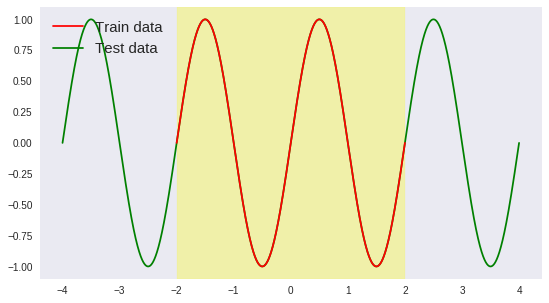

In [2]:
def quartic_function(args, x):
  return (args[0] * (x ** 4)) + (args[1] * (x ** 3)) + (args[2] * (x ** 2)) + (args[3] * x) + args[4]

def sinus_function(args, x):
  return np.sin(1*np.pi*x) 

def create_data(train_start, train_end, test_start, test_end, n, f, args):
  x_train = np.linspace(train_start, train_end, n)
  y_train = f(args, x_train)

  x_test = np.linspace(test_start, test_end, n)
  y_test = f(args, x_test)

  return (x_train, y_train, x_test, y_test)


NUM_EXAMPLES = 10000
train_start = -2
train_end = 2
test_start = -4
test_end = 4

x_train, y_train, x_test, y_test = create_data(train_start, train_end, test_start, test_end, 
                                               NUM_EXAMPLES, sinus_function,  [0,0,1,2,3])

visualize_predictions(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


# MLP test


In [0]:
import keras
import tensorflow.keras.backend as K
import tensorflow.keras.initializers as initializers
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, InputSpec, Dropout
from tensorflow.keras.initializers import RandomNormal, Constant, get


In [7]:


# build NN model
def mlp_model(learning_rate=0.01, loss="mse", metrics=["mae"]):

    model = Sequential()
    model.add(Dense(32, input_dim=1))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
        
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
        
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(lr=learning_rate),
                 loss=loss,
                 metrics=metrics)  
    
    return model
  
model=mlp_model()


Uninstalling Keras-2.2.2:
  Successfully uninstalled Keras-2.2.2
  Using cached https://files.pythonhosted.org/packages/34/7d/b1dedde8af99bd82f20ed7e9697aac0597de3049b1f786aa2aac3b9bd4da/Keras-2.2.2-py2.py3-none-any.whl


In [0]:
#callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}"

check_point = ModelCheckpoint('./{}.hdf5'.format(filepath), monitor='loss', verbose=1, save_best_only=True, period=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50)
#tensorboard = TensorBoard(log_dir='./logs/tensorboard/mlp'.format(filepath), histogram_freq=0, write_graph=True, write_images=False)

In [32]:
history=model.fit(x_train, y_train, validation_split=0.1, 
                  shuffle=True, batch_size=128, epochs=1000, 
                  callbacks=[reduce_lr, check_point], verbose=0) 


Epoch 00100: loss improved from inf to 0.02008, saving model to ./weights-improvement-100-0.35.hdf5

Epoch 00200: loss improved from 0.02008 to 0.00752, saving model to ./weights-improvement-200-0.16.hdf5

Epoch 00300: loss improved from 0.00752 to 0.00491, saving model to ./weights-improvement-300-0.21.hdf5

Epoch 00400: loss improved from 0.00491 to 0.00490, saving model to ./weights-improvement-400-0.21.hdf5

Epoch 00500: loss improved from 0.00490 to 0.00476, saving model to ./weights-improvement-500-0.21.hdf5

Epoch 00600: loss did not improve from 0.00476

Epoch 00700: loss did not improve from 0.00476

Epoch 00800: loss improved from 0.00476 to 0.00429, saving model to ./weights-improvement-800-0.21.hdf5

Epoch 00900: loss did not improve from 0.00429

Epoch 01000: loss did not improve from 0.00429


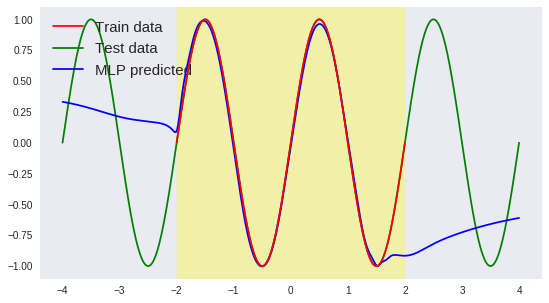

In [33]:
mlp_pred=model.predict(x_test)

visualize_predictions(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, mlp_pred=mlp_pred)

# NALU test

In [0]:
from keras.engine import Layer
from keras.engine import InputSpec
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

class NALU(Layer):
    def __init__(self, units,
                 use_gating=True,
                 kernel_W_initializer='glorot_uniform',
                 kernel_M_initializer='glorot_uniform',
                 gate_initializer='glorot_uniform',
                 kernel_W_regularizer=None,
                 kernel_M_regularizer=None,
                 gate_regularizer=None,
                 kernel_W_constraint=None,
                 kernel_M_constraint=None,
                 gate_constraint=None,
                 epsilon=1e-7):
        """
        Neural Arithmatic and Logical Unit.
        # Arguments:
            units: Output dimension.
            use_gating: Bool, determines whether to use the gating
                mechanism between W and m.
            kernel_W_initializer: Initializer for `W` weights.
            kernel_M_initializer: Initializer for `M` weights.
            gate_initializer: Initializer for gate `G` weights.
            kernel_W_regularizer: Regularizer for `W` weights.
            kernel_M_regularizer: Regularizer for `M` weights.
            gate_regularizer: Regularizer for gate `G` weights.
            kernel_W_constraint: Constraints on `W` weights.
            kernel_M_constraint: Constraints on `M` weights.
            gate_constraint: Constraints on gate `G` weights.
            epsilon: Small factor to prevent log 0.
        # Reference:
        - [Neural Arithmetic Logic Units](https://arxiv.org/abs/1808.00508)
        """
        super(NALU, self).__init__()
        self.units = units
        self.use_gating = use_gating
        self.epsilon = epsilon

        self.kernel_W_initializer = initializers.get(kernel_W_initializer)
        self.kernel_M_initializer = initializers.get(kernel_M_initializer)
        self.gate_initializer = initializers.get(gate_initializer)
        self.kernel_W_regularizer = regularizers.get(kernel_W_regularizer)
        self.kernel_M_regularizer = regularizers.get(kernel_M_regularizer)
        self.gate_regularizer = regularizers.get(gate_regularizer)
        self.kernel_W_constraint = constraints.get(kernel_W_constraint)
        self.kernel_M_constraint = constraints.get(kernel_M_constraint)
        self.gate_constraint = constraints.get(gate_constraint)

        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.W_hat = self.add_weight(shape=(input_dim, self.units),
                                     name='W_hat',
                                     initializer=self.kernel_W_initializer,
                                     regularizer=self.kernel_W_regularizer,
                                     constraint=self.kernel_W_constraint)

        self.M_hat = self.add_weight(shape=(input_dim, self.units),
                                     name='M_hat',
                                     initializer=self.kernel_M_initializer,
                                     regularizer=self.kernel_M_regularizer,
                                     constraint=self.kernel_M_constraint)

        if self.use_gating:
            self.G = self.add_weight(shape=(input_dim, self.units),
                                     name='G',
                                     initializer=self.gate_initializer,
                                     regularizer=self.gate_regularizer,
                                     constraint=self.gate_constraint)
        else:
            self.G = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, **kwargs):
        W = K.tanh(self.W_hat) * K.sigmoid(self.M_hat)
        m = K.exp(K.dot(K.log(K.abs(inputs) + self.epsilon), W))
        a = K.dot(inputs, W)

        if self.use_gating:
            g = K.sigmoid(K.dot(inputs, self.G))
            outputs = g * a + (1. - g) * m
        else:
            outputs = a + m

        return outputs

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'use_gating': self.use_gating,
            'kernel_W_initializer': initializers.serialize(self.kernel_W_initializer),
            'kernel_M_initializer': initializers.serialize(self.kernel_M_initializer),
            'gate_initializer': initializers.serialize(self.gate_initializer),
            'kernel_W_regularizer': regularizers.serialize(self.kernel_W_regularizer),
            'kernel_M_regularizer': regularizers.serialize(self.kernel_M_regularizer),
            'gate_regularizer': regularizers.serialize(self.gate_regularizer),
            'kernel_W_constraint': constraints.serialize(self.kernel_W_constraint),
            'kernel_M_constraint': constraints.serialize(self.kernel_M_constraint),
            'gate_constraint': constraints.serialize(self.gate_constraint),
            'epsilon': self.epsilon
        }

        base_config = super(NALU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


get_custom_objects().update({'NALU': NALU})


#%%
def nalu_model(mode="NALU", learning_rate=1e-2, loss="mse", metrics=["mae"]):
    ip = Input(shape=(1,))

    y = NALU(32)(ip)
    y = BatchNormalization()(y)
    y = NALU(32)(y)
    y = BatchNormalization()(y)
    y = NALU(32)(y)
    y = BatchNormalization()(y)
    y = NALU(32)(y)
    y = BatchNormalization()(y)
    y = Dense(1)(y)
       
    model = Model(ip, y)
    
    model.compile(optimizer=Adam(lr=learning_rate),
                 loss=loss,
                 metrics=metrics)
    
    return model
  
nalu_model=nalu_model("NALU")

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=50)

In [10]:
#%%
history=nalu_model.fit(x_train, y_train, shuffle=True, validation_split=0.1, batch_size=64, epochs=1000, callbacks=[reduce_lr], verbose=2) 


Train on 9000 samples, validate on 1000 samples
Epoch 1/1000
9000/9000 [==============================] - 6s 636us/step - loss: 0.2417 - mean_absolute_error: 0.3564 - val_loss: 0.6633 - val_mean_absolute_error: 0.7223
Epoch 2/1000
9000/9000 [==============================] - 4s 402us/step - loss: 0.1035 - mean_absolute_error: 0.2549 - val_loss: 0.8157 - val_mean_absolute_error: 0.8256
Epoch 3/1000
9000/9000 [==============================] - 4s 393us/step - loss: 0.0768 - mean_absolute_error: 0.2193 - val_loss: 2.2389 - val_mean_absolute_error: 1.4294
Epoch 4/1000
9000/9000 [==============================] - 4s 394us/step - loss: 0.0625 - mean_absolute_error: 0.1960 - val_loss: 1.0154 - val_mean_absolute_error: 0.9504
Epoch 5/1000
9000/9000 [==============================] - 4s 399us/step - loss: 0.0755 - mean_absolute_error: 0.2150 - val_loss: 1.3004 - val_mean_absolute_error: 1.0263
Epoch 6/1000
9000/9000 [==============================] - 4s 404us/step - loss: 0.0769 - mean_absolute

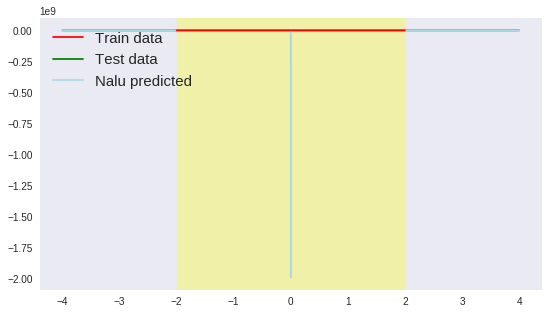

In [12]:

nalu_pred=nalu_model.predict(x_test)

visualize_predictions(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, nalu_pred=nalu_pred)



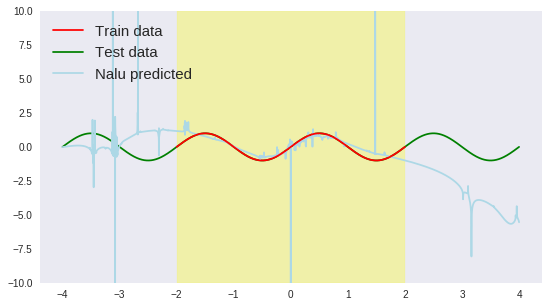

In [13]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

ax.plot(x_train, y_train, c="r", label="Train data", zorder=10)
ax.plot(x_test, y_test, c="g", label="Test data")  
ax.plot(x_test, nalu_pred, c="lightblue", label="Nalu predicted")
ax.set_ylim(-10, 10)    
ax.legend(loc=2, prop={'size': 15})
plt.axvspan(-2, 2, color='yellow', alpha=0.3)
plt.grid()
plt.show()